Import packages

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset
from torchvision import datasets, models
from torchvision.io import read_image
from torchvision.transforms import v2
from torcheval.metrics.functional import multiclass_f1_score
from collections import Counter
from tqdm.notebook import tqdm

Load and transform data

In [2]:
path = 'archive/UTKFace/'
data = pd.DataFrame({'file_path': [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]})
data['age'] = data['file_path'].apply(lambda x: int(x.split('_')[0]))
data['gender'] = data['file_path'].apply(lambda x: int(x.split('_')[1]))
# data['ethnicity'] = data['file_path'].apply(lambda x:  int(x.split('_')[2]))
data

,file_path,age,gender
0,9_1_2_20161219204347420.jpg.chip.jpg,9,1
1,36_0_1_20170117163203851.jpg.chip.jpg,36,0
2,86_1_0_20170120225751953.jpg.chip.jpg,86,1
3,26_1_0_20170116171048641.jpg.chip.jpg,26,1
4,1_1_2_20161219154612988.jpg.chip.jpg,1,1
...,...,...,...
23703,35_0_0_20170117155112202.jpg.chip.jpg,35,0
23704,52_0_3_20170119200211340.jpg.chip.jpg,52,0
23705,26_0_1_20170116010114628.jpg.chip.jpg,26,0
23706,28_0_1_20170117015458481.jpg.chip.jpg,28,0


In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 2])
        image = read_image(img_path)
        label_age = self.img_labels.iloc[idx, 0]
        label_gender = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label_age = self.target_transform(label_age)
            label_gender = self.target_transform(label_gender)
        return image, label_age, label_gender

In [4]:
dataset = ImageDataset(
    img_labels= data['file_path'],
    img_dir='archive/UTKFace/',
    transform=v2.Compose([
        v2.Resize(200, 200),
        v2.ToImage(),
        v2.ToDtype(torch.float, scale=True),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    target_transform=v2.Compose([
        torch.tensor,
        v2.ToDtype(torch.long)
    ])
)
dataset[0]

(Image([[[0.3647, 0.3529, 0.3412,  ..., 0.0784, 0.0824, 0.0784],
         [0.3647, 0.3529, 0.3373,  ..., 0.0784, 0.0824, 0.0784],
         [0.3569, 0.3490, 0.3333,  ..., 0.0784, 0.0784, 0.0784],
         ...,
         [0.1804, 0.1843, 0.1882,  ..., 0.6510, 0.6588, 0.6667],
         [0.1569, 0.1608, 0.1647,  ..., 0.6549, 0.6588, 0.6627],
         [0.1412, 0.1451, 0.1490,  ..., 0.6510, 0.6549, 0.6549]],
 
        [[0.4196, 0.4078, 0.3961,  ..., 0.1176, 0.1098, 0.1059],
         [0.4196, 0.4078, 0.3922,  ..., 0.1176, 0.1098, 0.1059],
         [0.4157, 0.4078, 0.3922,  ..., 0.1176, 0.1059, 0.1059],
         ...,
         [0.2510, 0.2549, 0.2588,  ..., 0.6627, 0.6706, 0.6784],
         [0.2275, 0.2314, 0.2353,  ..., 0.6549, 0.6588, 0.6627],
         [0.2118, 0.2157, 0.2196,  ..., 0.6510, 0.6549, 0.6549]],
 
        [[0.2902, 0.2784, 0.2667,  ..., 0.0863, 0.0824, 0.0784],
         [0.2902, 0.2784, 0.2627,  ..., 0.0863, 0.0824, 0.0784],
         [0.2863, 0.2784, 0.2627,  ..., 0.0863, 0.0784, 

Split data to training and test subsets

In [5]:
train_data, test_data = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)
train_data

array([ 5096, 19586,  9835, ...,   860, 15795, 23654])

In [6]:
train_data = Subset(dataset, train_data)
test_data = Subset(dataset, test_data)
test_data

Prepare data for fitting

In [9]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
for X, y1, y2 in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y1: {y1.shape} {y1.dtype}")
    print(f"Shape of y2: {y2.shape} {y2.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 200, 200])
Shape of y1: torch.Size([64]) torch.int64
Shape of y2: torch.Size([64]) torch.int64


Внезапный rofl

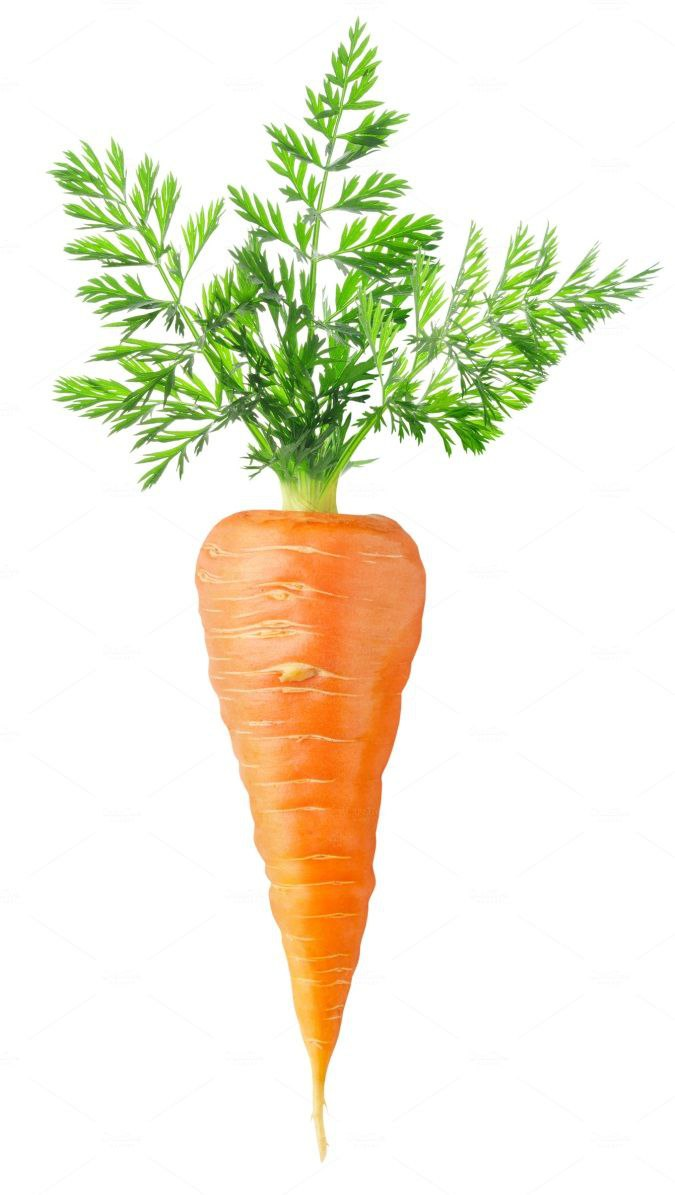

In [7]:
from PIL import Image

Image.open('/Users/vre/Downloads/carrot.jpeg')

Use GPU if available

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Make class of CNN

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Identity()
        self.mlp1 = nn.Sequential(
            nn.Linear(in_features=512, out_features=117, bias=True)
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.cnn(x)
        x1 = self.mlp1(x)
        x2 = self.mlp2(x)
        return x1, x2


model = Net().to(device)
model

NameError: name 'nn' is not defined

Create train function

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss1, correct1 = 0, 0
    train_loss2, correct2 = 0, 0
    for batch, (X, y1, y2) in enumerate(tqdm(dataloader)):
        X, y1, y2 = X.to(device), y1.to(device), y2.to(device)
        optimizer.zero_grad()
        pred1, pred2 = model(X)
        loss1 = loss_fn(pred1, y1)
        loss2 = loss_fn(pred2, y2)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        correct1 += (pred1.argmax(1) == y1).type(torch.float).sum().item()
        correct2 += (pred2.argmax(1) == y2).type(torch.float).sum().item()
    train_loss1 /= len(dataloader)
    train_loss2 /= len(dataloader)
    correct1 /= len(dataloader.dataset)
    correct2 /= len(dataloader.dataset)
    print(
        f"Train Error:\nAge:\nAccuracy: {(100 * correct1):>0.1f}%, Avg loss: {train_loss1:>8f}\nGender:\nAccuracy: {(100 * correct2):>0.1f}%, Avg loss: {train_loss2:>8f}\n")
    return [correct1, train_loss1, correct2, train_loss2]

Create test function

In [12]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss1, correct1 = 0, 0
    test_loss2, correct2 = 0, 0
    with torch.no_grad():
        for batch, (X, y1, y2) in enumerate(tqdm(dataloader)):
            X, y1, y2 = X.to(device), y1.to(device), y2.to(device)
            pred1, pred2 = model(X)
            loss1 = loss_fn(pred1, y1)
            loss2 = loss_fn(pred2, y2)
            test_loss1 += loss1.item()
            test_loss2 += loss2.item()
            correct1 += (pred1.argmax(1) == y1).type(torch.float).sum().item()
            correct2 += (pred2.argmax(1) == y2).type(torch.float).sum().item()
    test_loss1 /= len(dataloader)
    test_loss2 /= len(dataloader)
    correct1 /= len(dataloader.dataset)
    correct2 /= len(dataloader.dataset)
    print(
        f"Test Error:\nAge:\nAccuracy: {(100 * correct1):>0.1f}%, Avg loss: {test_loss1:>8f}\nGender:\nAccuracy: {(100 * correct2):>0.1f}%, Avg loss: {test_loss2:>8f}\n")
    return [correct1, test_loss1, correct2, test_loss2]

Teach model

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# scheduler = ...

Epoch 1
-------------------------------


  0%|          | 0/297 [00:00<?, ?it/s]

Train Error:
Age:
Accuracy: 15.9%, Avg loss: 3.323377
Gender:
Accuracy: 88.8%, Avg loss: 0.259171


  0%|          | 0/75 [00:00<?, ?it/s]

Test Error:
Age:
Accuracy: 16.6%, Avg loss: 3.303344
Gender:
Accuracy: 91.2%, Avg loss: 0.203479

Epoch 2
-------------------------------


  0%|          | 0/297 [00:00<?, ?it/s]

Train Error:
Age:
Accuracy: 19.7%, Avg loss: 2.923759
Gender:
Accuracy: 93.3%, Avg loss: 0.165464


  0%|          | 0/75 [00:00<?, ?it/s]

Test Error:
Age:
Accuracy: 18.4%, Avg loss: 3.033025
Gender:
Accuracy: 91.3%, Avg loss: 0.207518

Epoch 3
-------------------------------


  0%|          | 0/297 [00:00<?, ?it/s]

Train Error:
Age:
Accuracy: 23.5%, Avg loss: 2.700383
Gender:
Accuracy: 94.9%, Avg loss: 0.130992


  0%|          | 0/75 [00:00<?, ?it/s]

Test Error:
Age:
Accuracy: 16.4%, Avg loss: 3.047309
Gender:
Accuracy: 93.1%, Avg loss: 0.186504

Epoch 4
-------------------------------


  0%|          | 0/297 [00:00<?, ?it/s]

Train Error:
Age:
Accuracy: 29.5%, Avg loss: 2.441116
Gender:
Accuracy: 96.2%, Avg loss: 0.099305


  0%|          | 0/75 [00:00<?, ?it/s]

Test Error:
Age:
Accuracy: 16.2%, Avg loss: 3.249737
Gender:
Accuracy: 90.8%, Avg loss: 0.263154

Epoch 5
-------------------------------


  0%|          | 0/297 [00:00<?, ?it/s]

Train Error:
Age:
Accuracy: 39.7%, Avg loss: 2.056694
Gender:
Accuracy: 97.3%, Avg loss: 0.076227


  0%|          | 0/75 [00:00<?, ?it/s]

Test Error:
Age:
Accuracy: 14.0%, Avg loss: 3.758829
Gender:
Accuracy: 91.3%, Avg loss: 0.254436

Done!


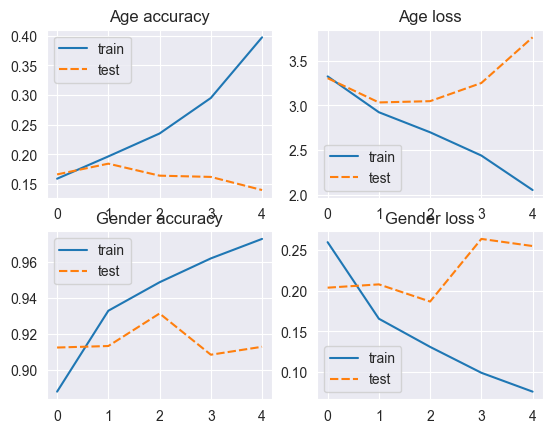

In [14]:
epochs = 5
metrics = [0] * epochs
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    metrics[t] = train(train_dataloader, model, loss_fn, optimizer) + test(test_dataloader, model, loss_fn)
print("Done!")
metrics = np.array(metrics)
fig, ax = plt.subplots(2, 2)
sns.lineplot(data=pd.DataFrame(metrics[:, ::4], columns=['train', 'test']), ax=ax[0, 0]).set(title='Age accuracy')
sns.lineplot(data=pd.DataFrame(metrics[:, 1::4], columns=['train', 'test']), ax=ax[0, 1]).set(title='Age loss')
sns.lineplot(data=pd.DataFrame(metrics[:, 2::4], columns=['train', 'test']), ax=ax[1, 0]).set(title='Gender accuracy')
sns.lineplot(data=pd.DataFrame(metrics[:, 3::4], columns=['train', 'test']), ax=ax[1, 1]).set(title='Gender loss')
plt.show()
# print(f'Best loss: {best_loss}')